In [14]:
import sys
sys.path.append('..')
from tool import *
from sklearn.metrics import r2_score,mean_squared_error

for year in range(2001,2021):
    yy=[]
    mm=[]
    v_rb=[]
    v_s=[]
    coords_y=[]
    coords_x=[]
    saz_Ls=[]
    for m in range(1,13):
        v_rb_m=[]
        v_s_m=[]
        rebuilding=rasterio.open(root_path+f"albedo_rebuilding/rebuilding2_albedo_{year}_{m}.tif").read(1)
        # rebuilding[rebuilding>=1]=np.nan#(sza>70)
        source=rasterio.open(root_path+f'albedo_rebuilding/source2_{year}_{m}_sw_albedo2.tif').read(1)
        n=0
        print(year,m)
        for i in range(1000000):
            y,x=random.randint(0,40075),random.randint(0,80151)
            v_rebuilding,v_source=rebuilding[y,x],source[y,x]
            if v_rebuilding!=0 and v_source!=0:
                if np.isnan(v_rebuilding) or np.isnan(v_source):
                    continue
                else:
                    if v_rebuilding>=1:
                        saz_Ls.append(1)
                        v_rebuilding-=1
                    else:
                        saz_Ls.append(0)
                    yy.append(year)
                    mm.append(m)
                    v_rb_m.append(v_rebuilding)
                    v_s_m.append(v_source)
                    coords_y.append(y)
                    coords_x.append(x)
                    n+=1
                    if n==50000:
                        break
        v_s+=v_s_m
        v_rb+=v_rb_m
        
        print(r2_score(v_s_m,v_rb_m))
        print(mean_squared_error(v_s_m,v_rb_m))
    print('------------------------------all------------------------------')
    print(r2_score(v_s,v_rb))
    print(mean_squared_error(v_s,v_rb))
    pd.DataFrame.from_dict({'year':yy,'month':mm,'y':coords_y,'x':coords_x,'truth':v_s,'rebuilding':v_rb,'sza_L':saz_Ls}).to_csv(root_path+f'albedo_rebuilding/rebuilding_usemean_val_{year}.csv')




<70
r2: 0.9556866075432662
rmse: 0.05298936739095922
<85
r2: 0.9539974658468923
rmse: 0.05909415927766903


In [ ]:
kk=[]
for y in range(2001,2021):
    
    # print(f'{y} <70')
    kk.append(pd.read_csv(root_path+f'albedo_rebuilding/rebuilding_usemean_val_{y}.csv'))
kkk=pd.concat(kk)
kkk.to_csv(root_path+f'albedo_rebuilding/rebuilding_usemean_val.csv')


kkk_70=kkk[kkk.sza_L<1]
print('<70')
print('r2:',r2_score(kkk_70['truth'],kkk_70['rebuilding']))
print('rmse:',mean_squared_error(kkk_70['truth'],kkk_70['rebuilding']))

print('<85')
print('r2:',r2_score(kkk['truth'],kkk['rebuilding']))
print('rmse:',mean_squared_error(kkk['truth'],kkk['rebuilding']))

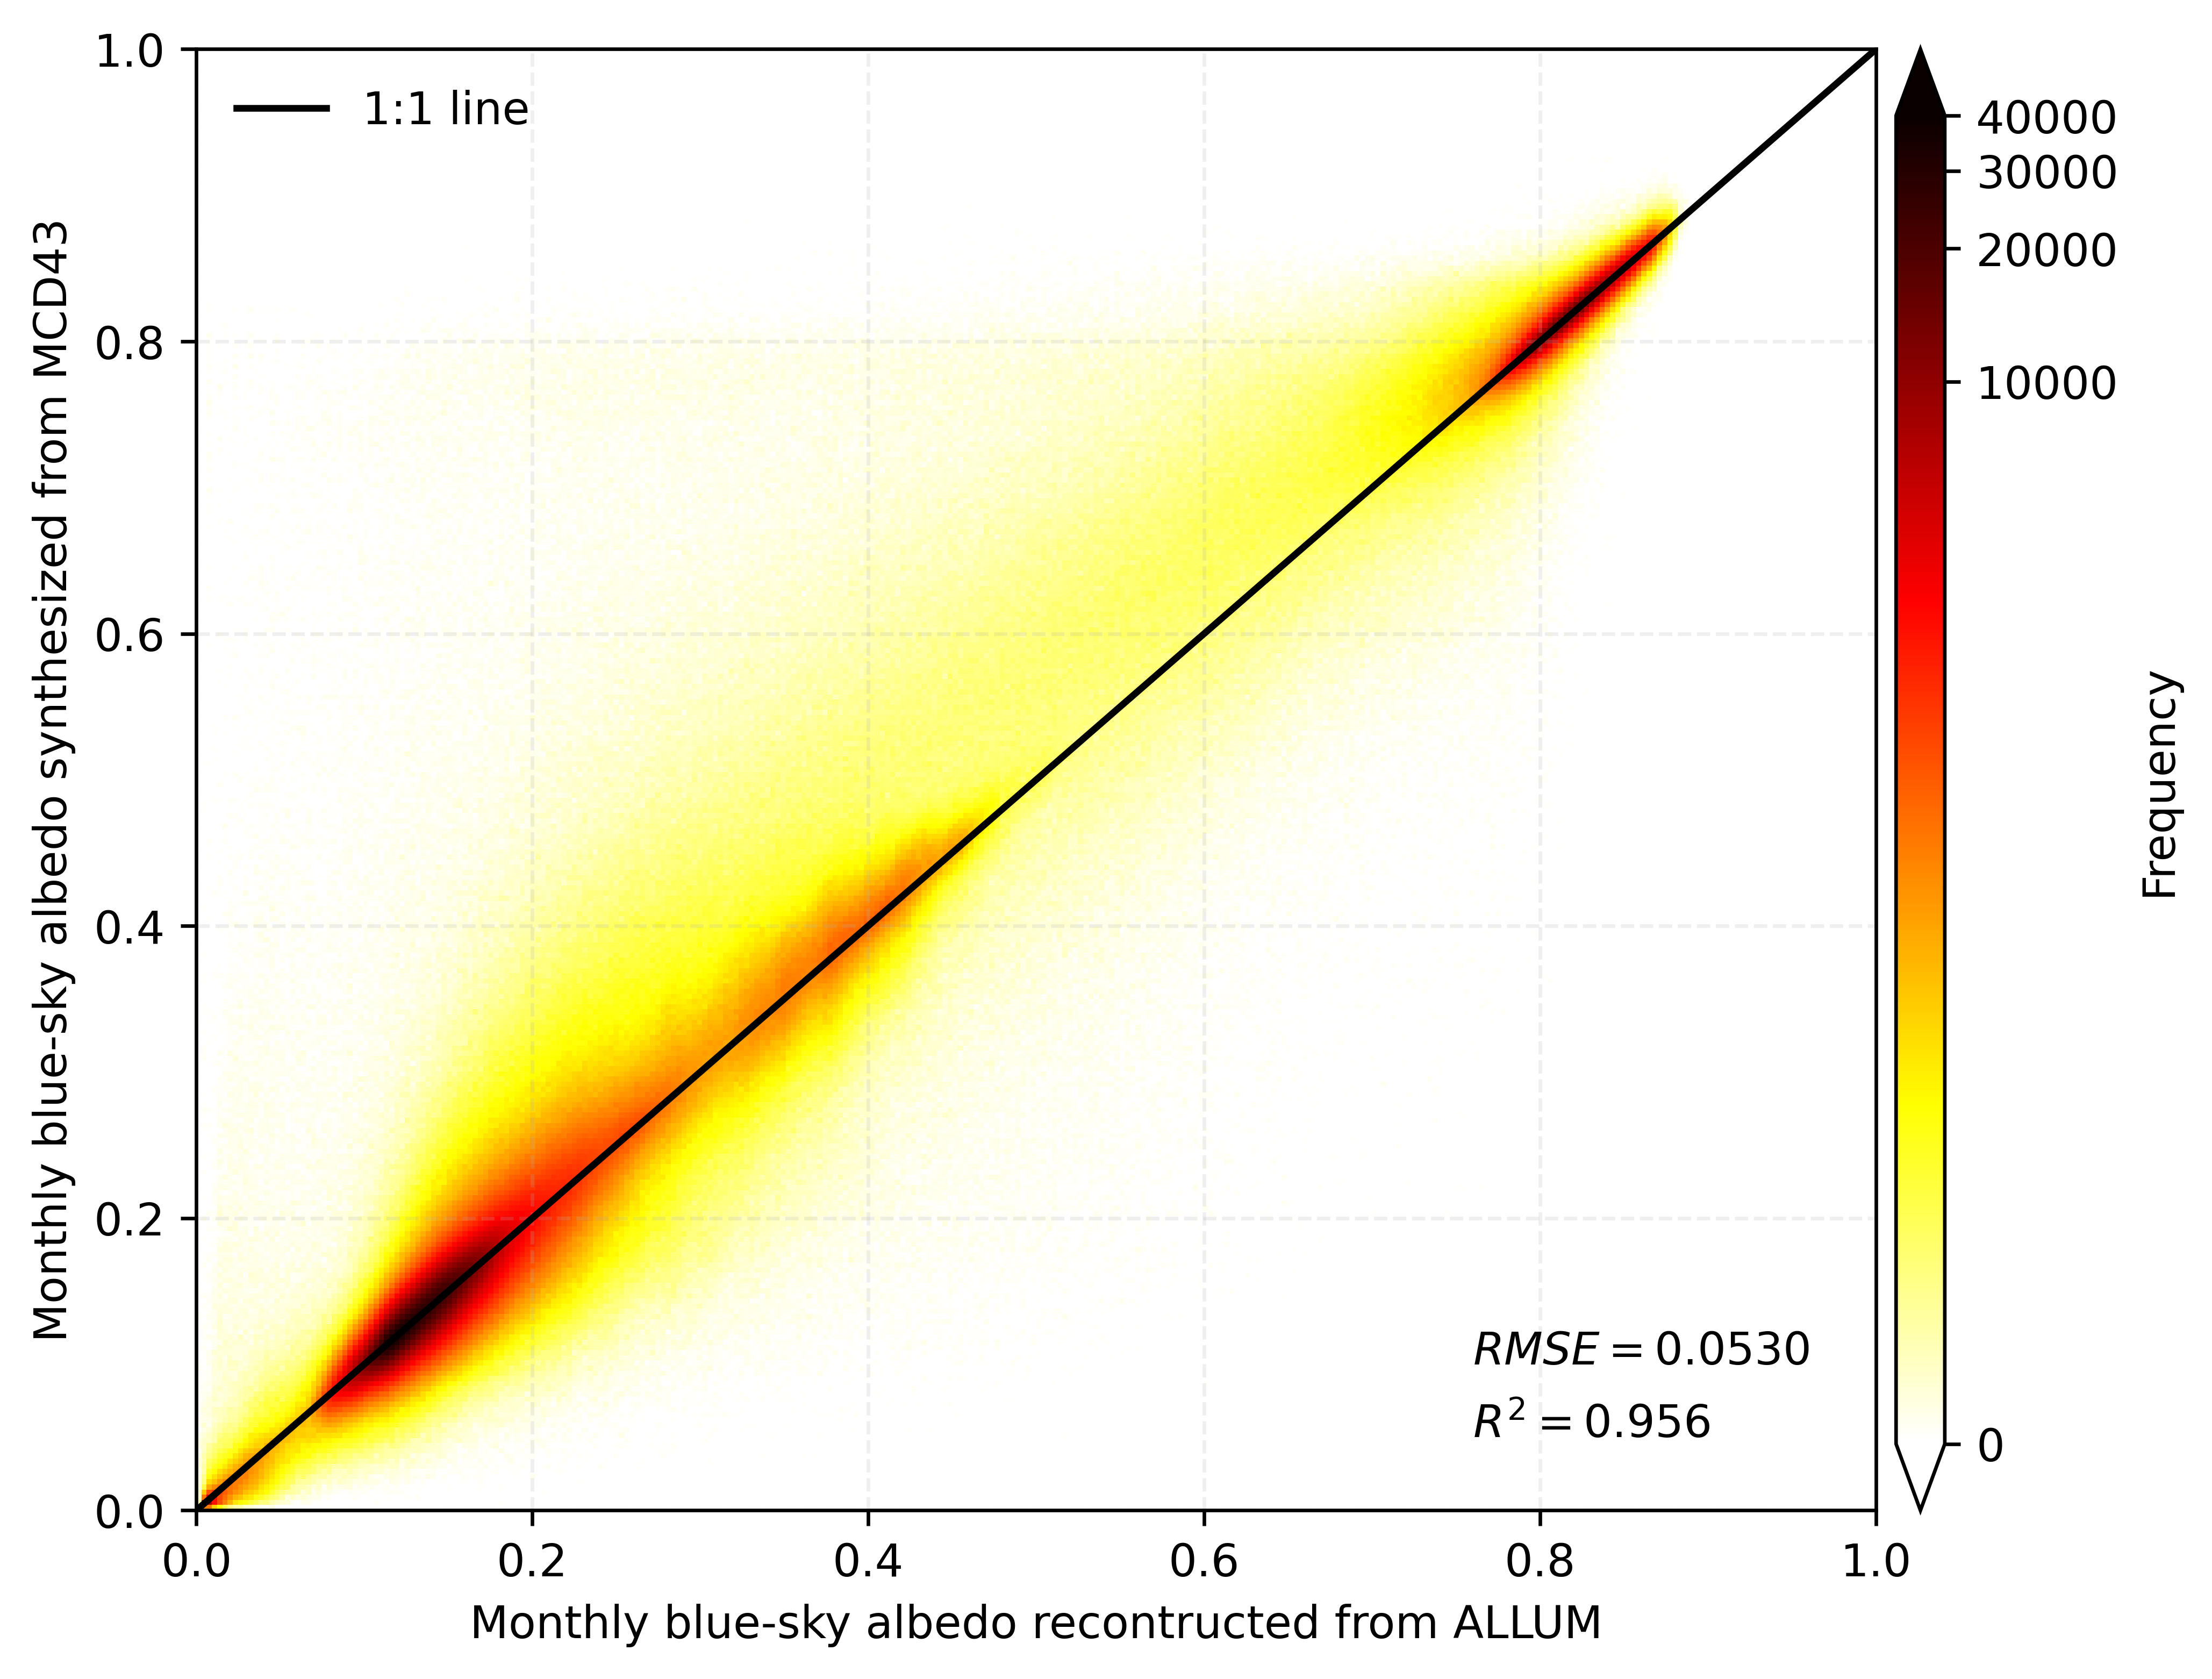

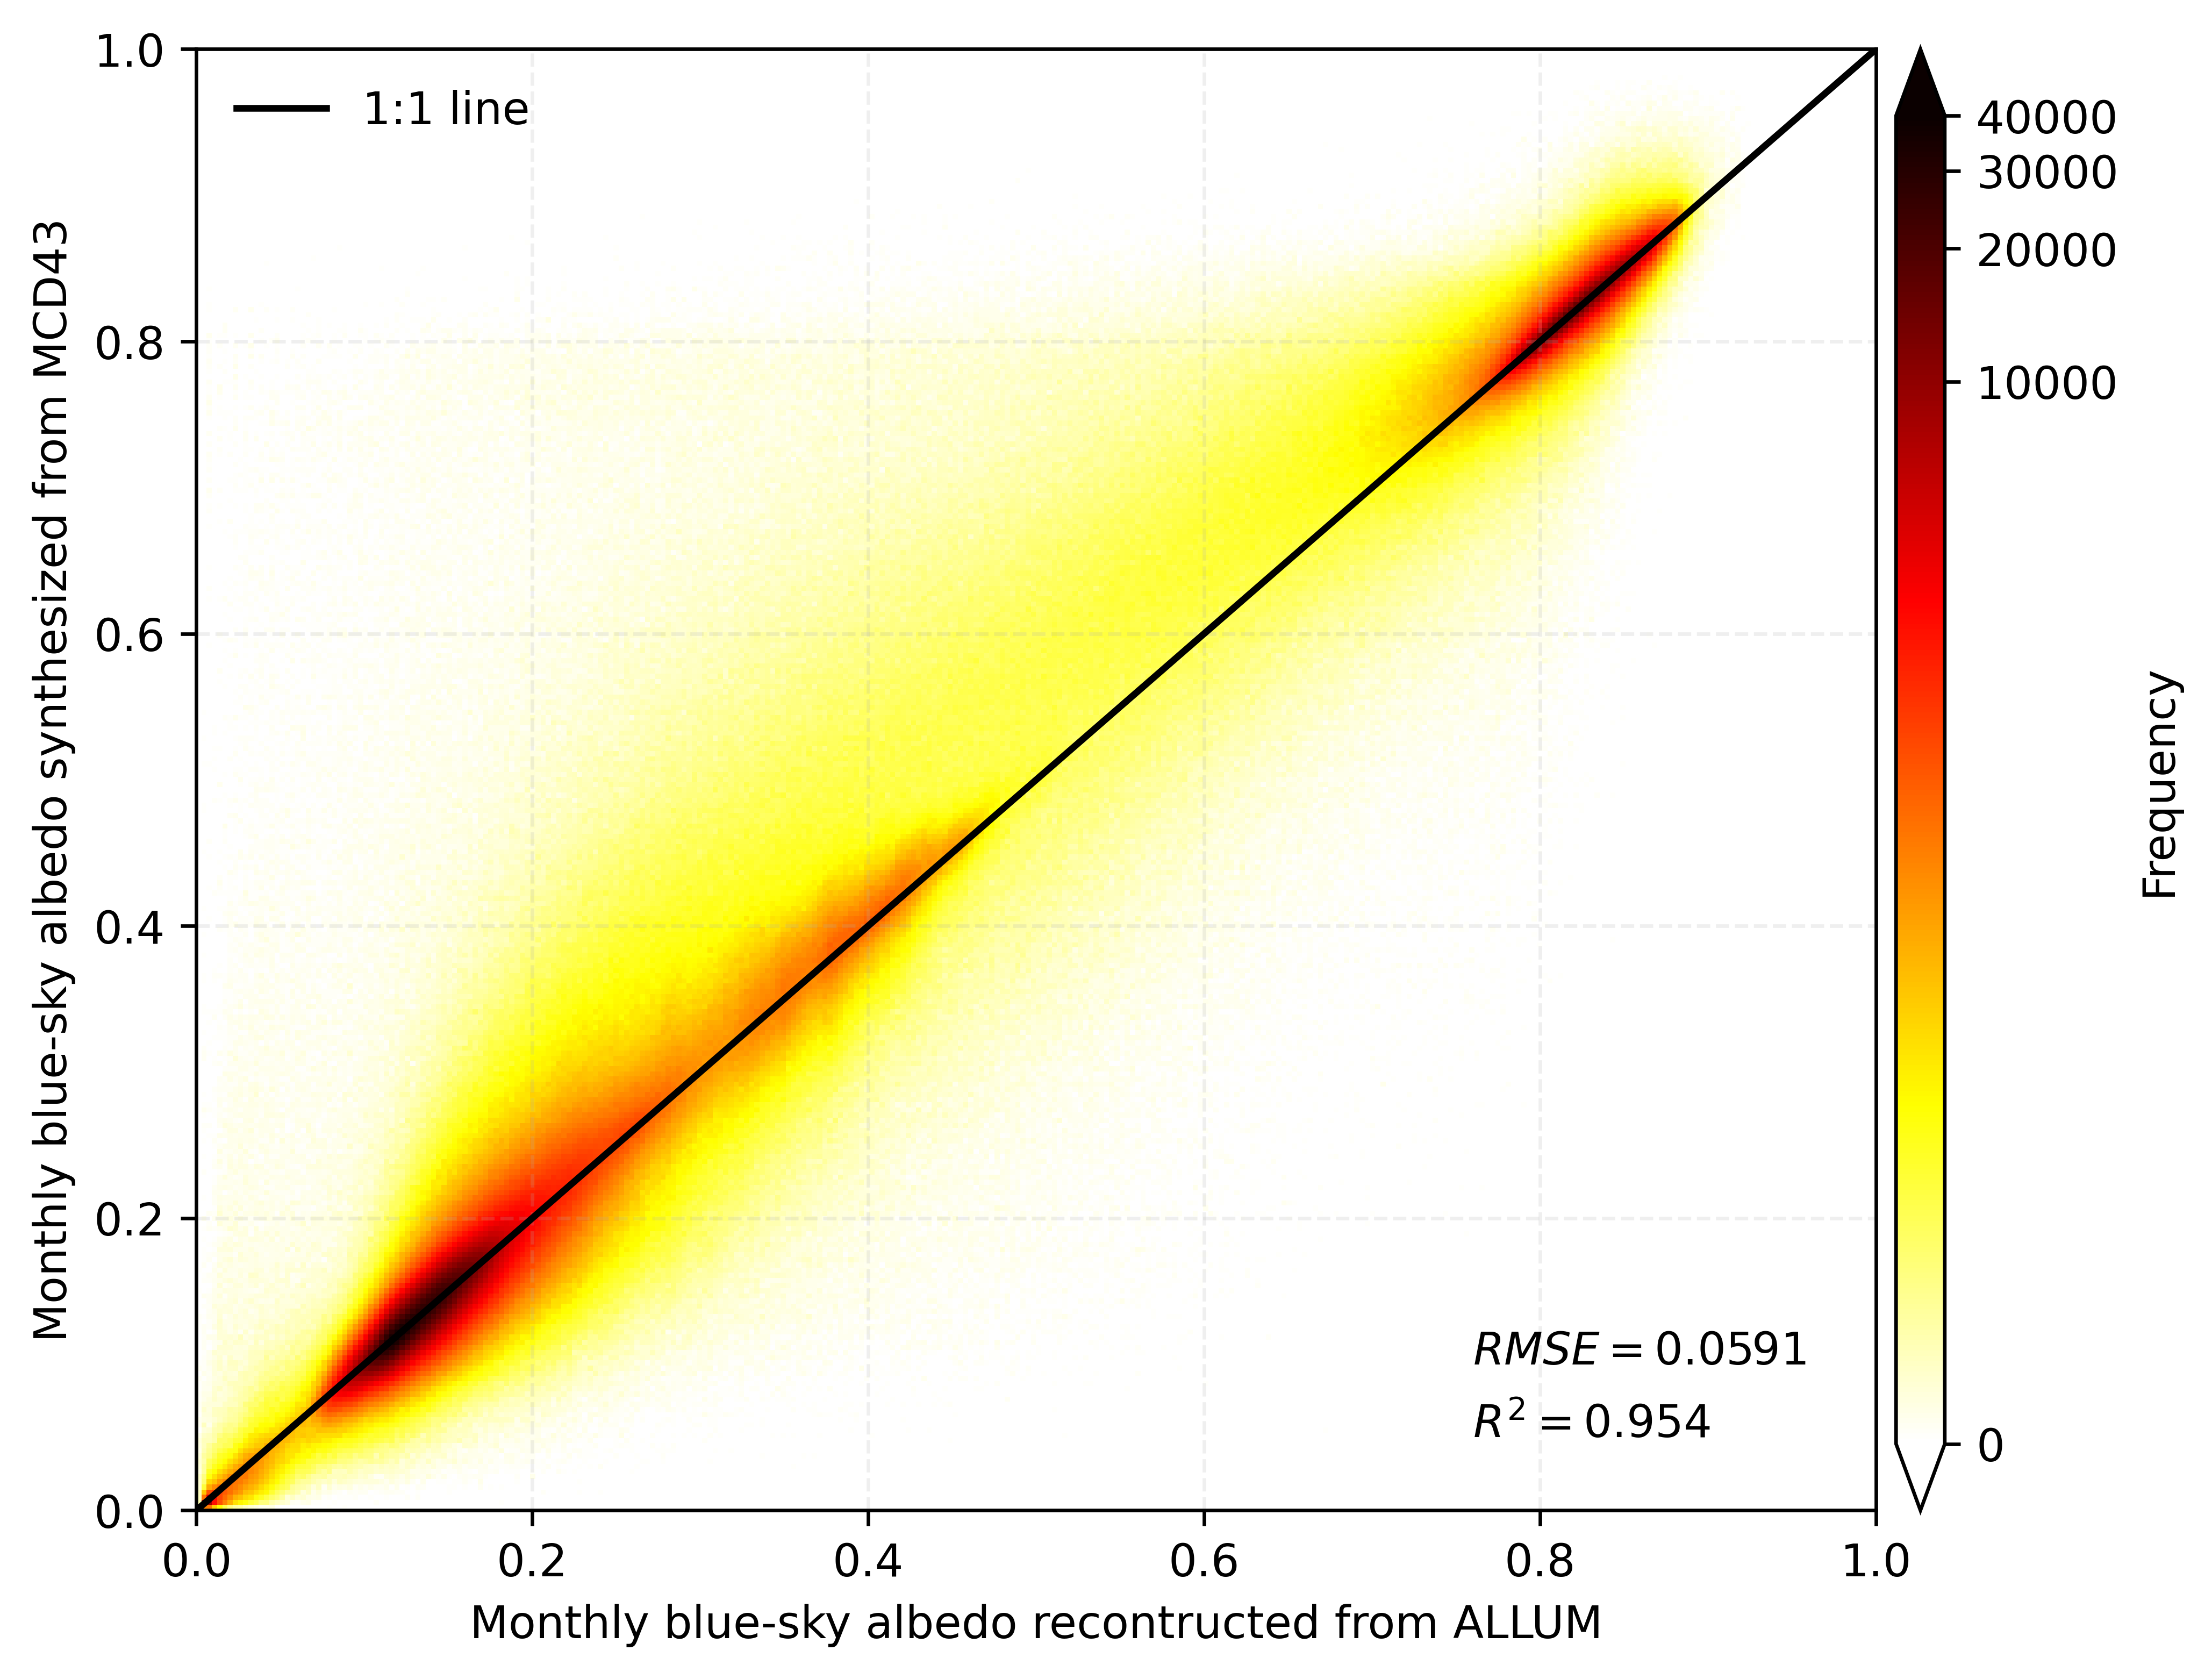

In [15]:
from scipy import  stats
from matplotlib import rcParams
from statistics import mean
from sklearn.metrics import *
from scipy.stats import pearsonr
for sza_L in [70,85]:
    if sza_L==70: 
        x,y=kkk_70['rebuilding'],kkk_70['truth']
    else:
        x,y=kkk['rebuilding'],kkk['truth']
    R2 = r2_score(x,y)
    xy = np.vstack([x, y])
    # z=stats.gaussian_kde(xy)(xy)
    # idx=z.argsort()
    # x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
    def slope(xs, ys):
        m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
        b = mean(ys) - m * mean(xs)
        return m, b
    k, b = slope(x, y)
    regression_line = []
    for a in range(100000):
        regression_line.append((k * a/100000) + b)
        
    MSE = mean_squared_error(y,x)  
    RMSE = np.power(MSE, 0.5)
    R2 = r2_score(y,x)

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    import mpl_scatter_density
    from astropy.visualization import LogStretch
    from astropy.visualization.mpl_normalize import ImageNormalize
    from matplotlib.ticker import MultipleLocator
    norm = ImageNormalize(vmin=0., vmax=40000, stretch=LogStretch())
    fig = plt.figure(figsize=(8, 6), dpi=600)
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    # scatter = ax.scatter(x, y, marker='o', c=z * 100, edgecolors=None, s=5, cmap='RdBu_r',  alpha=0.8)
    # cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    density = ax.scatter_density(x, y, cmap='hot_r',norm=norm)
    cbar=fig.colorbar(density, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    cbar.ax.yaxis.set_major_locator(MultipleLocator(10000))
    plt.plot([0, 1], [0, 1], 'black', lw=1.5, label='1:1 line') 
    # plt.plot([i/100000 for i in range(100000)], regression_line, 'black', lw=1.5, label='Regression Line')  
    ax.grid(True, linestyle='--', alpha=0.2)


    plt.annotate('$R^2=%.3f$' % R2,(0.76,0.05))
    plt.annotate('$RMSE=%.4f$' % RMSE,(0.76,0.1))
    # plt.text(28,-12.5, '$R^2=%.3f$' % R2)
    # plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE)
    plt.xlabel(r'Monthly blue-sky albedo recontructed from ALLUM',fontsize=10)
    plt.ylabel(r'Monthly blue-sky albedo synthesized from MCD43',fontsize=10)
    plt.axis([0, 1, 0,1])  # 设置线的范围
    ax.legend(loc='upper left', frameon = False)
    plt.savefig(f'./figure/rebuilding500_{sza_L}_val_kernel.pdf',dpi=600)
    plt.savefig(f'./figure/rebuilding500_{sza_L}_val_kernel.png',dpi=600)
    plt.show()

In [7]:
rr70=[]
mm70=[]
for m in range(1,13):
    kkk1=kkk_70[kkk_70['month']==m]
    rr70.append(r2_score(kkk1['truth'],kkk1['rebuilding']))
    mm70.append(np.sqrt(mean_squared_error(kkk1['truth'],kkk1['rebuilding'])))
rr85=[]
mm85=[]
for m in range(1,13):
    kkk1=kkk[kkk['month']==m]
    rr85.append(r2_score(kkk1['truth'],kkk1['rebuilding']))
    mm85.append(np.sqrt(mean_squared_error(kkk1['truth'],kkk1['rebuilding'])))

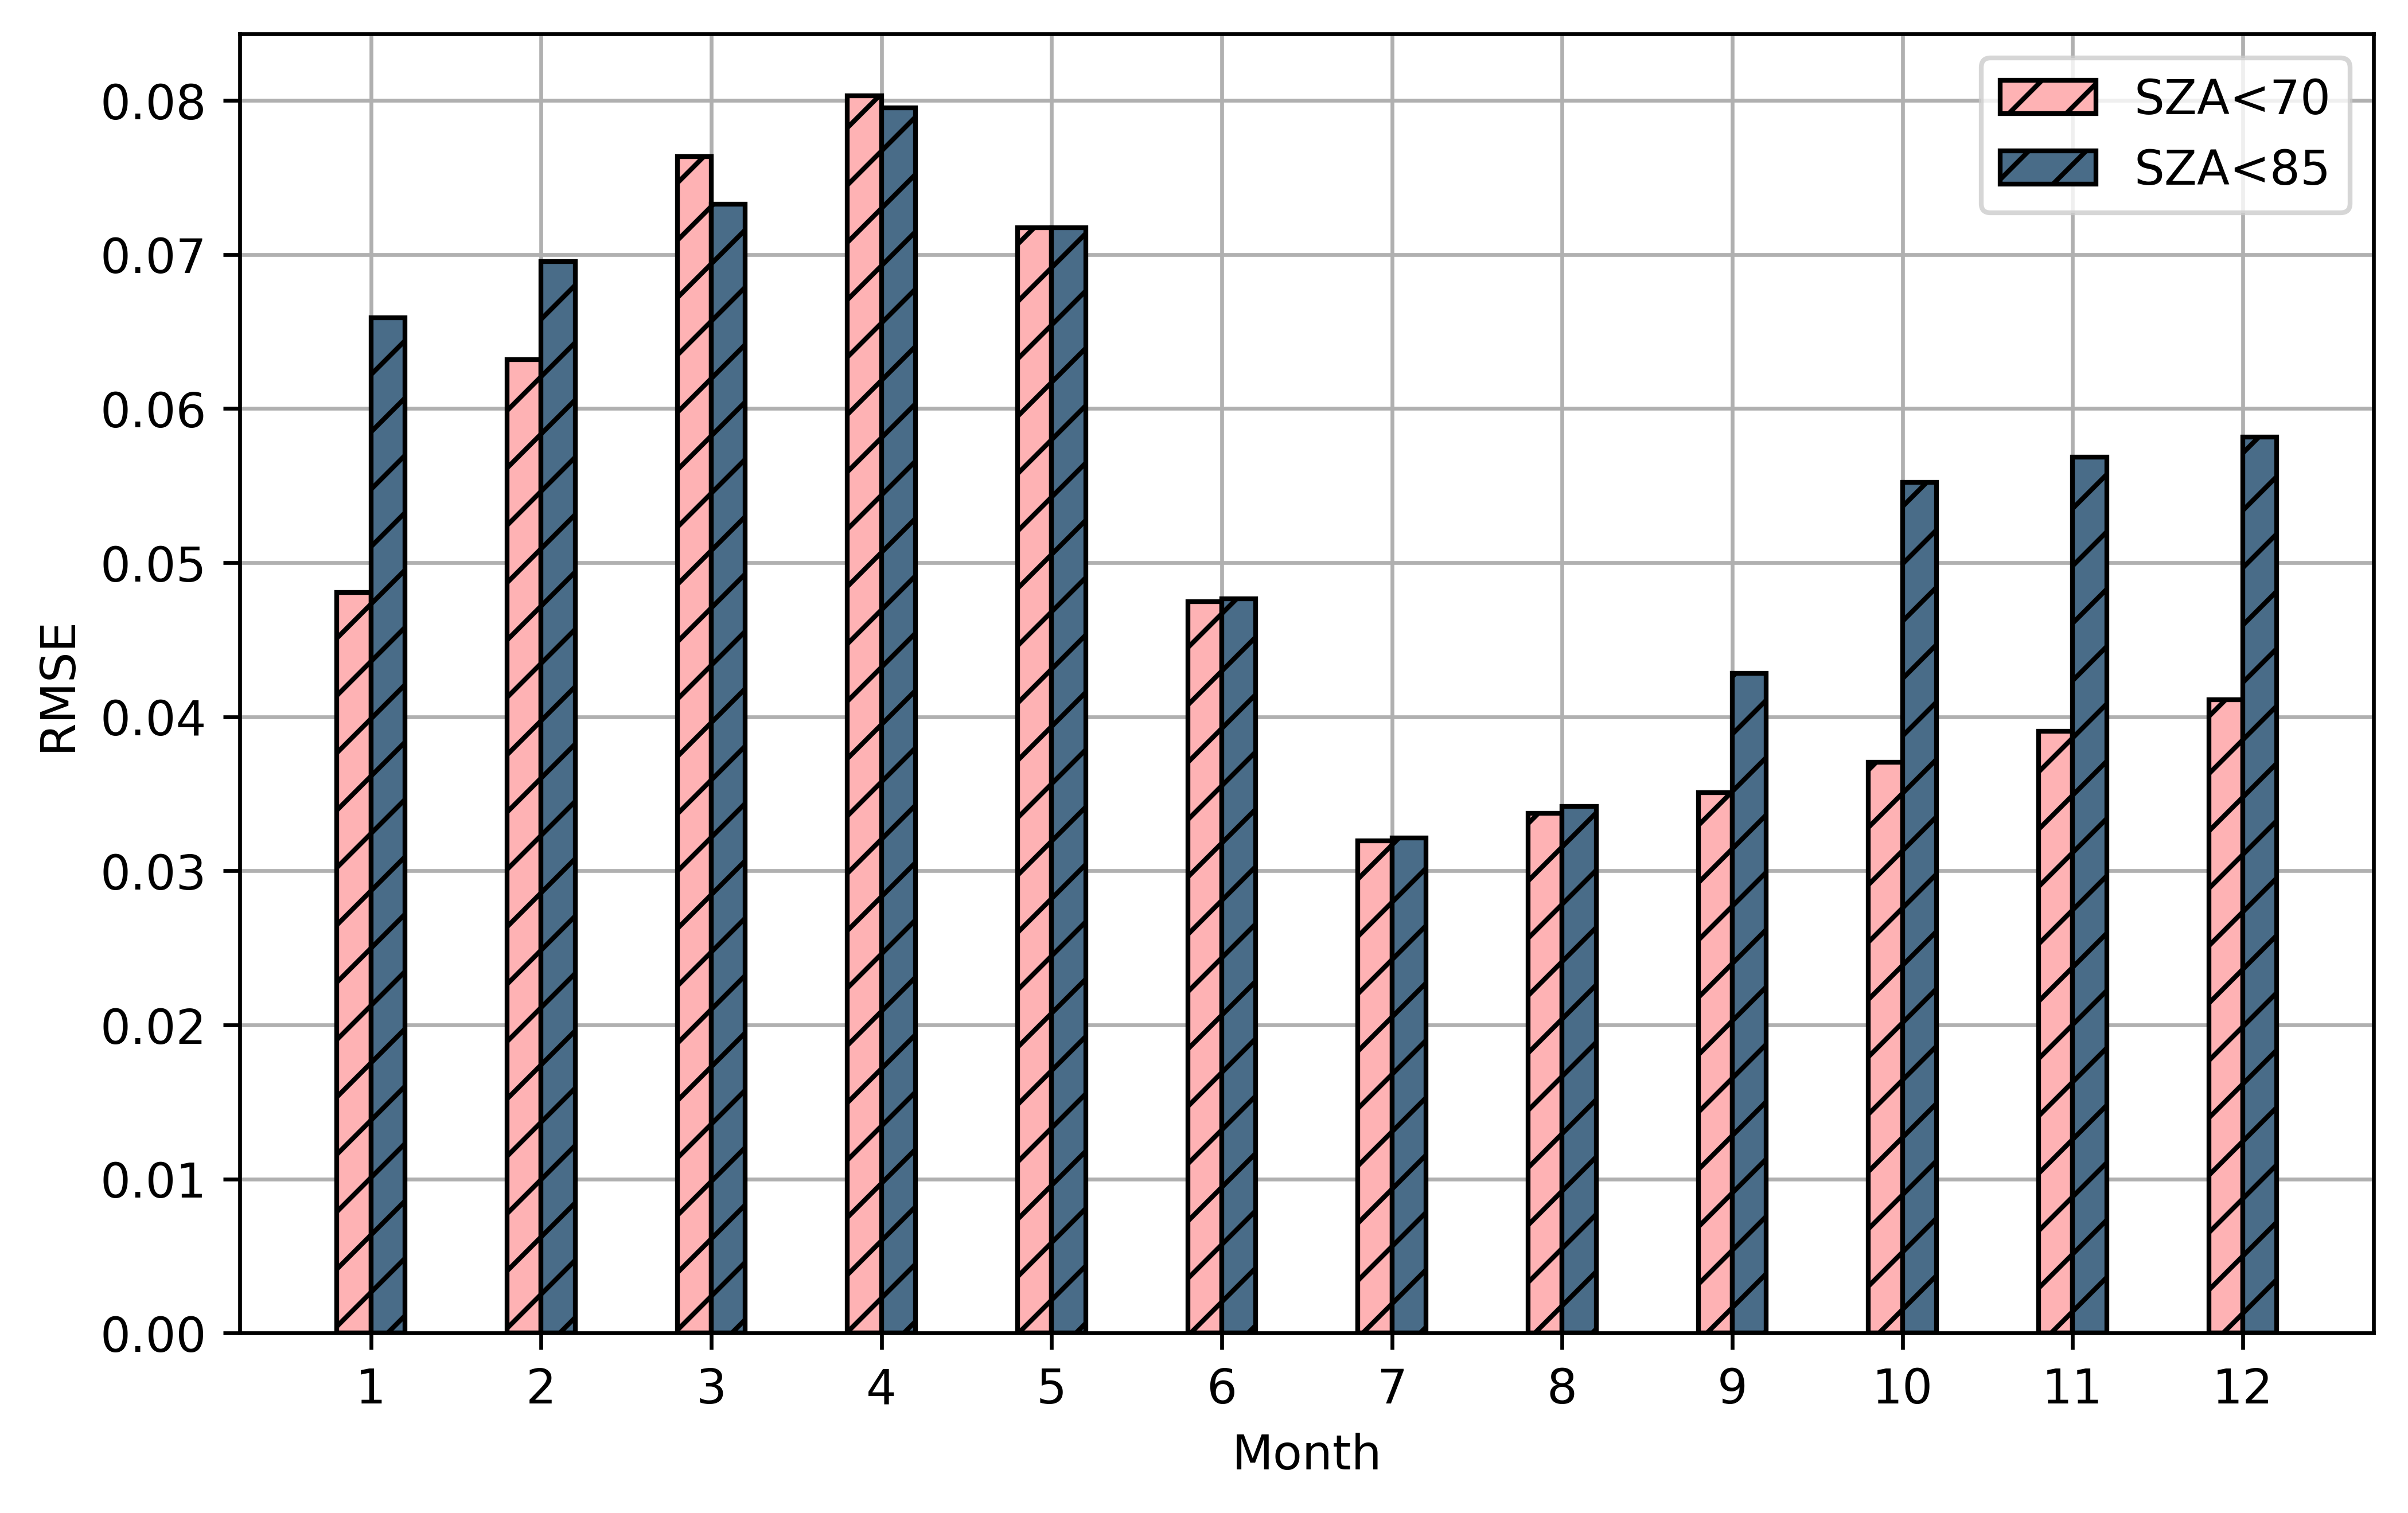

In [15]:
plt.figure(figsize=(8,5),dpi=600)
width = 0.2
x = np.arange(1,13)-width/2
x2=x+width
plt.grid(b=None, which='major',zorder=0 )
plt.bar(x,mm70,width=width,color='#FEB2B4',edgecolor='black',label='SZA<70', zorder=100,hatch='//')
plt.bar(x2,mm85,width=width,color='#496C88',edgecolor='black',label='SZA<85', zorder=100,hatch='//')
plt.xlabel(r'Month')
plt.ylabel(r'RMSE')
plt.xticks(range(1,13))
plt.legend()
plt.savefig('./figure/rebuilding500_RMSE.pdf',dpi=600)
plt.savefig('./figure/rebuilding500_RMSE.png',dpi=600)
plt.show()

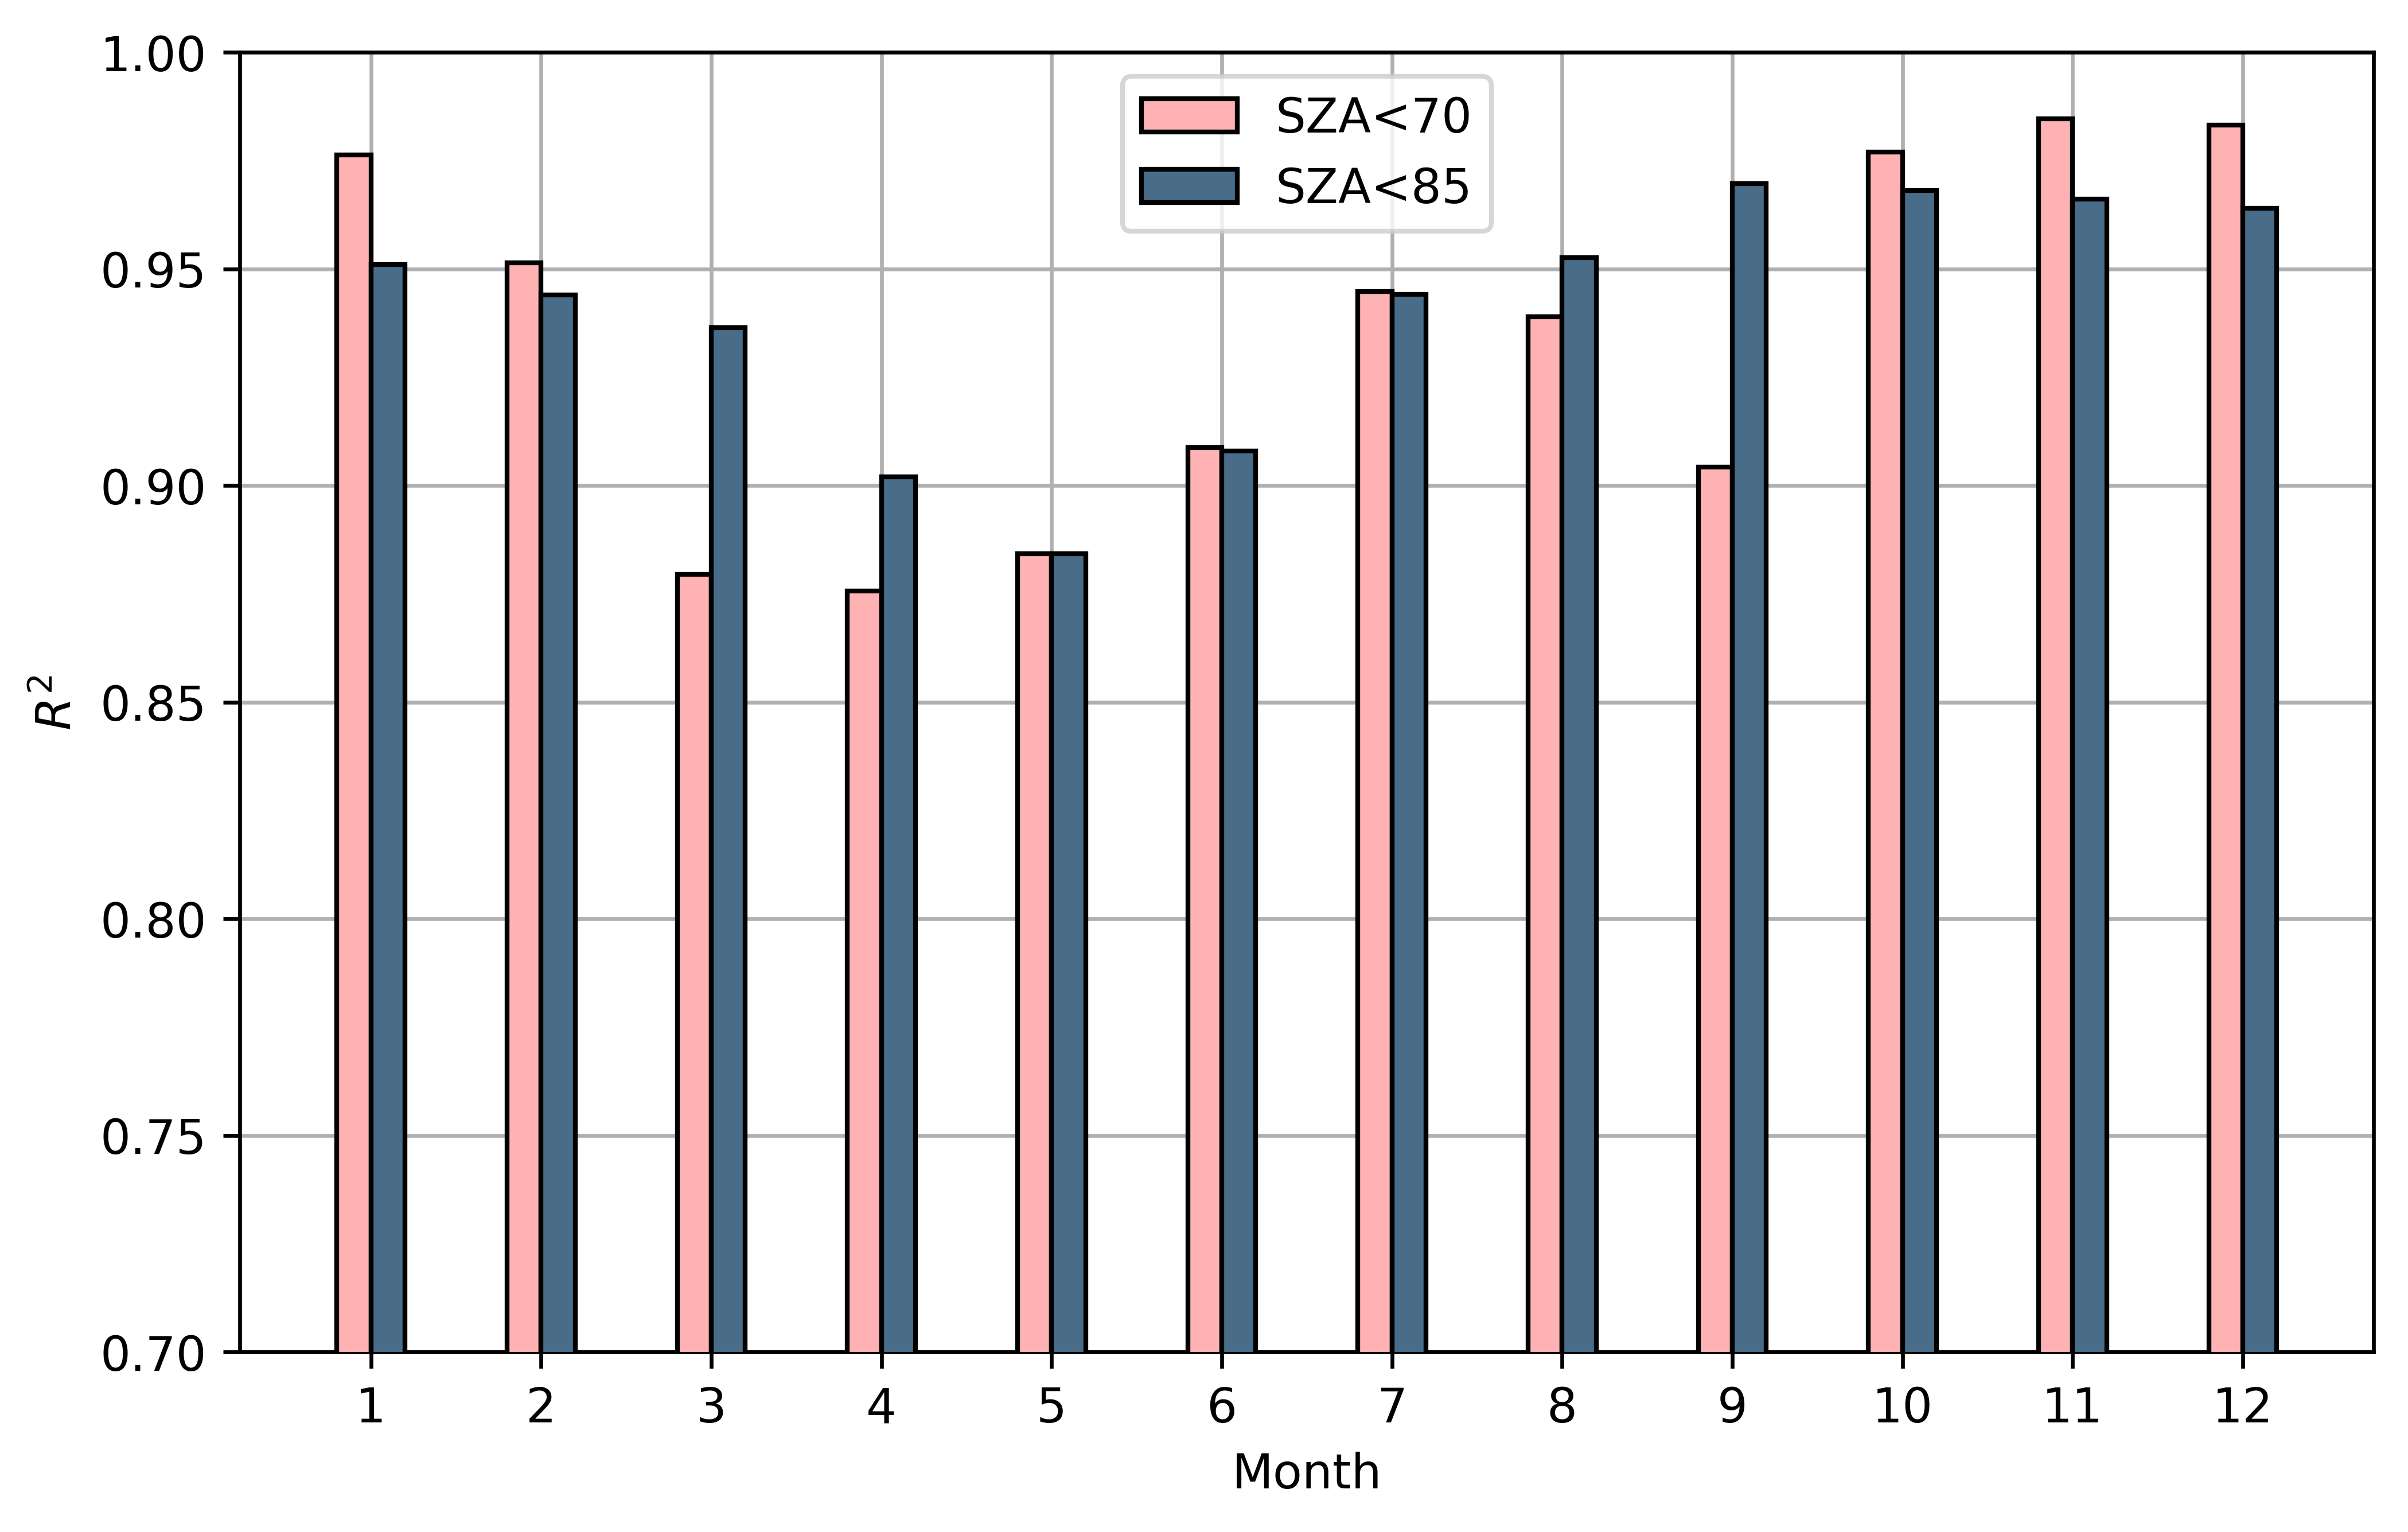

In [16]:
plt.figure(figsize=(8,5),dpi=600)
width = 0.2
x = np.arange(1,13)-width/2
x2=x+width
plt.grid(b=None, which='major',zorder=0 )
plt.bar(x,rr70,width=width,color='#FEB2B4',edgecolor='black',label='SZA<70', zorder=100)
plt.bar(x2,rr85,width=width,color='#496C88',edgecolor='black',label='SZA<85', zorder=100)
plt.ylim(0.7,1)
plt.xlabel(r'Month',)
plt.ylabel(r'$R^2$')
plt.xticks(range(1,13))
plt.legend()
plt.savefig('./figure/rebuilding500_R2.pdf',dpi=600)
plt.savefig('./figure/rebuilding500_png.pdf',dpi=600)
plt.show()